In [1]:

'''
For the fine-tuning of the VGG-Face network for the emotion
recognition task, we investigated various options in our preliminary
analysis. We found that combining weight decay and dropout for regularization
gives the best results on the FER validation set. We carry
out a multi-stage fine-tuning. In the first stage, we fine-tune on the
FER public test set, and run weight updates for five epochs. In the second
stage, we update the upper layers (higher than layer 27) using'''

''' We then fine-tune the VGG-face model on FER 2013
dataset, using both the training and the public test set; during
training we use data augmentation by jittering the scale, flipping
and rotating the faces. The aim is to make the network more robust
to small misalignment of the faces. We also apply a strong dropout
on the last layer of the VGG (keeping only 5% of the nodes) to
prevent over-fitting. We achieve a performance of 71.2% on the
FER private test set, which is slightly higher than the previously
published results '''

'''During the training of the deep networks, we oversample the training
images by rotating them around their center by a random angle between 
−15° and 15°, and by circularly shifting the images in the horizontal and 
vertical directions by an amount no more than 20% of the image size. 
This approach helps our network to be more robust against alignment errors. 
In Fig. 2, we show the training curves of two stages of fine-tuning of the 
network with the FER dataset, where we set the learning rate and weight 
decay to 0.0005, momentum to 0.9, and dropout probability to 0.8 [25].'''


'During the training of the deep networks, we oversample the training\nimages by rotating them around their center by a random angle between \n\xe2\x88\x9215\xc2\xb0 and 15\xc2\xb0, and by circularly shifting the images in the horizontal and \nvertical directions by an amount no more than 20% of the image size. \nThis approach helps our network to be more robust against alignment errors. \nIn Fig. 2, we show the training curves of two stages of fine-tuning of the \nnetwork with the FER dataset, where we set the learning rate and weight \ndecay to 0.0005, momentum to 0.9, and dropout probability to 0.8 [25].'

### VGG16-Face model

In [2]:
import VGG_FACE
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms

In [3]:
model = VGG_FACE.VGG_FACE

model.load_state_dict(torch.load('VGG_FACE.pth'))

#model.eval() #this will let you pass an input through the model and evaluate it? without training?


### Dataset: FERplus

In [4]:
import os
from skimage import io
import pandas as pd
import numpy as np
import argparse
import torch
from torch.utils.data import Dataset, DataLoader

In [5]:
df = pd.read_csv('all-data/FERPlus/fer2013new.csv')
df.dropna(axis=0, how='any')

,Usage,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,Training,fer0000000.png,4,0,0,1,3,2,0,0,0,0
1,Training,fer0000001.png,6,0,1,1,0,0,0,0,2,0
2,Training,fer0000002.png,5,0,0,3,1,0,0,0,1,0
3,Training,fer0000003.png,4,0,0,4,1,0,0,0,1,0
4,Training,fer0000004.png,9,0,0,1,0,0,0,0,0,0
5,Training,fer0000005.png,6,0,0,1,0,0,1,1,1,0
6,Training,fer0000006.png,2,0,0,8,0,0,0,0,0,0
7,Training,fer0000007.png,0,10,0,0,0,0,0,0,0,0
8,Training,fer0000008.png,0,10,0,0,0,0,0,0,0,0
9,Training,fer0000009.png,0,0,6,0,0,0,4,0,0,0


In [252]:
class FaceEmotionsDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform = None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.emotions_frame = pd.read_csv(csv_file)
        self.emotions_frame.dropna(axis=0, how='any', inplace=True)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.emotions_frame)

    def __getitem__(self, idx):
        img_name = self.emotions_frame.iloc[idx][1]
        
        img_path = os.path.join(self.root_dir, img_name)
        image = io.imread(img_path)
        #this takes the most highest ranked emotion. if two emotions have the same ranking, it just takes the first one
        emotion = np.argmax(self.emotions_frame.iloc[idx,2:].as_matrix())
        if (emotion == 1 or emotion == 2):
            emotion = 2
        elif (emotion > 2 and emotion < 8):
            emotion = 0
        else:
            emotion = 1
        
        sample = {'image': image, 'emotion': emotion}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
    
    

In [253]:
face_emotions = FaceEmotionsDataset(csv_file = 'all-data/FERPlus/fer2013new_training.csv', 
                                    root_dir = 'all-data/FERPlus/data/FER2013Train')

print(type(face_emotions[0]['emotion']))

<type 'int'>


In [279]:
from torchvision.datasets import ImageFolder
from skimage import transform
from PIL import Image
from skimage import io; io.use_plugin('matplotlib')

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, emotion = sample['image'], sample['emotion']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        #print(image.shape)
        #image = image.transpose((2, 0, 1))
        image = np.expand_dims(image,0)
        y = np.copy(image)
        z = np.copy(image)
        z = np.concatenate((y,z), axis=0)    
        image = np.concatenate((image,z), axis=0)
        return {'image': torch.from_numpy(image),
                'emotion': emotion}

class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, emotion = sample['image'], sample['emotion']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        #emotion = emotion - [left, top]

        return {'image': image, 'emotion': emotion}

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or tuple): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, emotion = sample['image'], sample['emotion']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        
        #emotion = emotion * [new_w / w, new_h / h]

        return {'image': img, 'emotion': emotion}


imgTransform = transforms.Compose([Rescale(256), #scale to 256x256
                                   #transforms.CenterCrop(224), #crops the image at center to 224x224
                                   RandomCrop(224),
                                   ToTensor()
                                   ])
                                   #, #turn the jpg/pil/wahtever image into a tensor
                                   #transforms.Normalize(mean = [0.485, 0.456, 0.406], #normalize with these vals
                                                        #std=[0.229, 0.224, 0.225])])
                                    ##HOW TO GET NORMALIZED VALUES?
                                    #to add: jitter/rotate data augmentation, flipping, 
                                   
#this doesn't work because the data is organized w a csv file w prob distrib of labels 
#instead of a single ground truth
#see this paper: https://arxiv.org/pdf/1608.01041.pdf
#trainset = FaceEmotionsDataset(csv_file = 'all-data/FERPlus/fer2013new_training.csv', 
#                                    root_dir = 'all-data/FERPlus/data/FER2013Train', transform = imgTransform)
#valset = FaceEmotionsDataset(csv_file = 'all-data/FERPlus/fer2013new_validation.csv', 
#                                    root_dir = 'all-data/FERPlus/data/FER2013Valid', transform = imgTransform)

trainset = FaceEmotionsDataset(csv_file = 'all-data/FERPlus/fer2013new_short.csv', 
                                    root_dir = 'all-data/FERPlus/data/FER2013Train', transform = imgTransform)
valset = FaceEmotionsDataset(csv_file = 'all-data/FERPlus/fer2013new_short.csv', 
                                    root_dir = 'all-data/FERPlus/data/FER2013Train', transform = imgTransform)

trainLoader = torch.utils.data.DataLoader(trainset, batch_size = 9, 
                                          shuffle = True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(valset, batch_size = 9, 
                                       shuffle = False, num_workers = 0)


In [280]:
for (i, sample) in enumerate(trainLoader):
    inputs = sample['image']
    labels = sample['emotion']
    print("{}, {}".format(inputs, labels))
    break


( 0 , 0 ,.,.) = 
  0.3076  0.3059  0.3042  ...   0.2806  0.2833  0.2860
  0.3060  0.3038  0.3018  ...   0.2837  0.2858  0.2879
  0.3063  0.3039  0.3019  ...   0.2849  0.2867  0.2884
           ...             ⋱             ...          
  0.2916  0.2942  0.2950  ...   0.6102  0.5712  0.5321
  0.2954  0.2967  0.2962  ...   0.6347  0.6049  0.5750
  0.2991  0.2992  0.2975  ...   0.6592  0.6386  0.6180

( 0 , 1 ,.,.) = 
  0.3076  0.3059  0.3042  ...   0.2806  0.2833  0.2860
  0.3060  0.3038  0.3018  ...   0.2837  0.2858  0.2879
  0.3063  0.3039  0.3019  ...   0.2849  0.2867  0.2884
           ...             ⋱             ...          
  0.2916  0.2942  0.2950  ...   0.6102  0.5712  0.5321
  0.2954  0.2967  0.2962  ...   0.6347  0.6049  0.5750
  0.2991  0.2992  0.2975  ...   0.6592  0.6386  0.6180

( 0 , 2 ,.,.) = 
  0.3076  0.3059  0.3042  ...   0.2806  0.2833  0.2860
  0.3060  0.3038  0.3018  ...   0.2837  0.2858  0.2879
  0.3063  0.3039  0.3019  ...   0.2849  0.2867  0.2884
           

### Function to train the model

In [281]:
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm

HBox(children=(IntProgress(value=0, max=1), HTML(value=u'')))

('label is', Variable containing:
 1
[torch.LongTensor of size 1]
)


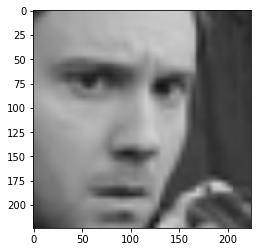

In [294]:
import matplotlib.pyplot as plt
t = tqdm(trainLoader)
for (i, (sample)) in enumerate(t):
    
    inputs = Variable(sample['image'] ).float()#.cpu()
    labels = Variable(sample['emotion'])
    #model = modified_pretrained.cpu()
    #outputs = modified_pretrained(inputs)
    #print(outputs)
    #print(inputs)
    print("label is", labels[i])
    showme = (inputs.data.numpy()[i]).transpose(1,2,0)
    plt.imshow(showme)
    plt.show(showme.all)
    
    if i == 20:
        break
    #outputs = model(inputs)

In [289]:
import lab_utils
def train_model(network, criterion, optimizer, trainLoader, valLoader, n_epochs = 10, use_gpu = False):
    if use_gpu:
        network = network.cuda()
        criterion = criterion.cuda()
        
    t_loss, t_acc, v_loss, v_acc = (np.zeros(n_epochs) for i in range(4))    
    
    # Training loop.
    for epoch in range(0, n_epochs):
        correct = 0.0
        cum_loss = 0.0
        counter = 0

        # Make a pass over the training data.
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        network.train()  # This is important to call before training!
        for (i, (sample)) in enumerate(t):
            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(sample['image']).float()
            print("inputs", inputs[0])
            labels = Variable(sample['emotion'])
            print("requires grad?", inputs.requires_grad)
            #print("training", sample['emotion'])
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            
            print("outputs", outputs.data)
            print("labels", labels.data)

            # Backward pass:
            optimizer.zero_grad()
            # Loss is a variable, and calling backward on a Variable will
            # compute all the gradients that lead to that Variable taking on its
            # current value.
            #a = list(network.parameters())[0].clone()
            print("loss",loss.data)
            loss.backward() 
            
            for param in network.parameters():
                print("gradient values:", param.grad.data.sum())
                break
            
            # Weight and bias updates.
            optimizer.step()
            b = list(network.parameters())[0].clone()
            #print(torch.equal(a.data, b.data))

            # logging information.
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            counter += inputs.size(0)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)
            
        t_loss[epoch] = (cum_loss/len(t))
        t_acc[epoch] = (100*correct/counter)

        # Make a pass over the validation data.
        correct = 0.0
        cum_loss = 0.0
        counter = 0
        t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
        network.eval()  # This is important to call before evaluating!
        for (i, (sample)) in enumerate(t):
            #print("on iter {}".format(i))
            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(sample['image'] ).float()
            labels = Variable(sample['emotion'])
            #print("validation", sample['emotion'])
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()
            
            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            
            
            # logging information.
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            counter += inputs.size(0)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)
            
        v_loss[epoch] = (cum_loss/len(t))
        v_acc[epoch] = (100*correct/counter)
        
                
    lab_utils.generate_plots(t_loss, v_loss, t_acc, v_acc, n_epochs)
            

### set learning rate, loss, optimizer, all variable stuff

In [287]:
pretrained_model = model
#print(pretrained_model)
#print(list(pretrained_model.children())[:-2]) #gets rid of the last linear layer and softmax
modified_pretrained = nn.Sequential(*list(pretrained_model.children())[:-2]) 

#print(modified_pretrained)

modified_pretrained.add_module('38', nn.Sequential(VGG_FACE.Lambda(lambda x: x.view(1,-1) if 1==len(x.size()) else x ),nn.Linear(4096,3)))
#modified_pretrained.add_module('39', nn.Softmax())

print(modified_pretrained)

Sequential (
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU ()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU ()
  (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU ()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU ()
  (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU ()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU ()
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU ()
  (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU ()
  (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [288]:
#"where we set the learning rate and weight decay to 0.0005, momentum to 0.9, and dropout probability to 0.8 [25]"
learningRate = 5e-4
weightDecay = 0.0005
moment = 0.9




# Definition of our network. #how to change the last fc layer of the model to nn.linear(4096, 7) instead of (4096, 2622)?
#model.fc = nn.Linear(512, 2)

#Definition of our loss. #maybe need to change this?
criterion = nn.CrossEntropyLoss()

# Definition of optimization strategy. # maybe need to change this?
optimizer = optim.SGD(modified_pretrained.parameters(), lr = learningRate, nesterov = True, weight_decay = weightDecay, momentum= moment)
# following this model: https://arxiv.org/pdf/1711.04598.pdf

train_model(modified_pretrained, criterion, optimizer, trainLoader, valLoader, n_epochs = 10, use_gpu = True)

HBox(children=(IntProgress(value=0, description=u'Training epoch 0: ', max=1), HTML(value=u'')))

('inputs', Variable containing:
( 0 ,.,.) = 
  0.1177  0.1224  0.1271  ...   0.6985  0.6942  0.6902
  0.1154  0.1207  0.1259  ...   0.6990  0.6948  0.6909
  0.1131  0.1189  0.1247  ...   0.6995  0.6954  0.6916
           ...             ⋱             ...          
  0.4261  0.4500  0.4738  ...   0.6592  0.6577  0.6561
  0.4129  0.4343  0.4557  ...   0.6570  0.6555  0.6539
  0.3997  0.4186  0.4375  ...   0.6548  0.6533  0.6517

( 1 ,.,.) = 
  0.1177  0.1224  0.1271  ...   0.6985  0.6942  0.6902
  0.1154  0.1207  0.1259  ...   0.6990  0.6948  0.6909
  0.1131  0.1189  0.1247  ...   0.6995  0.6954  0.6916
           ...             ⋱             ...          
  0.4261  0.4500  0.4738  ...   0.6592  0.6577  0.6561
  0.4129  0.4343  0.4557  ...   0.6570  0.6555  0.6539
  0.3997  0.4186  0.4375  ...   0.6548  0.6533  0.6517

( 2 ,.,.) = 
  0.1177  0.1224  0.1271  ...   0.6985  0.6942  0.6902
  0.1154  0.1207  0.1259  ...   0.6990  0.6948  0.6909
  0.1131  0.1189  0.1247  ...   0.6995  0.6954 

HBox(children=(IntProgress(value=0, description=u'Validation epoch 0: ', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Training epoch 1: ', max=1), HTML(value=u'')))

('inputs', Variable containing:
( 0 ,.,.) = 
  0.0030  0.0023  0.0017  ...   0.0411  0.0383  0.0354
  0.0024  0.0018  0.0013  ...   0.0401  0.0374  0.0346
  0.0018  0.0014  0.0010  ...   0.0391  0.0365  0.0339
           ...             ⋱             ...          
  0.0000  0.0000  0.0000  ...   0.1418  0.1396  0.1374
  0.0000  0.0000  0.0000  ...   0.1403  0.1381  0.1359
  0.0000  0.0000  0.0000  ...   0.1388  0.1366  0.1344

( 1 ,.,.) = 
  0.0030  0.0023  0.0017  ...   0.0411  0.0383  0.0354
  0.0024  0.0018  0.0013  ...   0.0401  0.0374  0.0346
  0.0018  0.0014  0.0010  ...   0.0391  0.0365  0.0339
           ...             ⋱             ...          
  0.0000  0.0000  0.0000  ...   0.1418  0.1396  0.1374
  0.0000  0.0000  0.0000  ...   0.1403  0.1381  0.1359
  0.0000  0.0000  0.0000  ...   0.1388  0.1366  0.1344

( 2 ,.,.) = 
  0.0030  0.0023  0.0017  ...   0.0411  0.0383  0.0354
  0.0024  0.0018  0.0013  ...   0.0401  0.0374  0.0346
  0.0018  0.0014  0.0010  ...   0.0391  0.0365 

HBox(children=(IntProgress(value=0, description=u'Validation epoch 1: ', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Training epoch 2: ', max=1), HTML(value=u'')))

('inputs', Variable containing:
( 0 ,.,.) = 
  0.2023  0.2088  0.2152  ...   0.2010  0.1943  0.1876
  0.1977  0.2060  0.2140  ...   0.1953  0.1880  0.1808
  0.2023  0.2117  0.2202  ...   0.1890  0.1825  0.1759
           ...             ⋱             ...          
  0.1660  0.1634  0.1607  ...   0.2523  0.2429  0.2335
  0.1649  0.1645  0.1634  ...   0.2808  0.2681  0.2554
  0.1638  0.1656  0.1661  ...   0.3093  0.2933  0.2773

( 1 ,.,.) = 
  0.2023  0.2088  0.2152  ...   0.2010  0.1943  0.1876
  0.1977  0.2060  0.2140  ...   0.1953  0.1880  0.1808
  0.2023  0.2117  0.2202  ...   0.1890  0.1825  0.1759
           ...             ⋱             ...          
  0.1660  0.1634  0.1607  ...   0.2523  0.2429  0.2335
  0.1649  0.1645  0.1634  ...   0.2808  0.2681  0.2554
  0.1638  0.1656  0.1661  ...   0.3093  0.2933  0.2773

( 2 ,.,.) = 
  0.2023  0.2088  0.2152  ...   0.2010  0.1943  0.1876
  0.1977  0.2060  0.2140  ...   0.1953  0.1880  0.1808
  0.2023  0.2117  0.2202  ...   0.1890  0.1825 

HBox(children=(IntProgress(value=0, description=u'Validation epoch 2: ', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Training epoch 3: ', max=1), HTML(value=u'')))

('inputs', Variable containing:
( 0 ,.,.) = 
  0.2758  0.2747  0.2735  ...   0.1944  0.1879  0.1768
  0.2737  0.2716  0.2695  ...   0.1959  0.1894  0.1783
  0.2605  0.2591  0.2577  ...   0.1927  0.1872  0.1769
           ...             ⋱             ...          
  0.2287  0.2272  0.2257  ...   0.3244  0.3391  0.3404
  0.2228  0.2213  0.2199  ...   0.3035  0.3148  0.3140
  0.2169  0.2154  0.2140  ...   0.2827  0.2904  0.2877

( 1 ,.,.) = 
  0.2758  0.2747  0.2735  ...   0.1944  0.1879  0.1768
  0.2737  0.2716  0.2695  ...   0.1959  0.1894  0.1783
  0.2605  0.2591  0.2577  ...   0.1927  0.1872  0.1769
           ...             ⋱             ...          
  0.2287  0.2272  0.2257  ...   0.3244  0.3391  0.3404
  0.2228  0.2213  0.2199  ...   0.3035  0.3148  0.3140
  0.2169  0.2154  0.2140  ...   0.2827  0.2904  0.2877

( 2 ,.,.) = 
  0.2758  0.2747  0.2735  ...   0.1944  0.1879  0.1768
  0.2737  0.2716  0.2695  ...   0.1959  0.1894  0.1783
  0.2605  0.2591  0.2577  ...   0.1927  0.1872 

KeyboardInterrupt: 

In [ ]:
#torch.save(modified_pretrained, 'trained_model.pt')
